# aptos beta

In [84]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import os
import shutil

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import random

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.nasnet import NASNetLarge

from tensorflow.keras.applications.nasnet import preprocess_input

from tensorflow import losses

from tensorflow.keras import models

from tensorflow.keras.preprocessing import image

import sklearn

#### paths

In [2]:
PROJECT_DIR = Path('/notebooks/storage/aptos')
IMAGE_DIR = PROJECT_DIR/'images'
TRAIN_DIR = IMAGE_DIR/'train'
TEST_DIR = IMAGE_DIR/'test'
TRAIN_CSV = PROJECT_DIR/'train.csv'
TEST_CSV = PROJECT_DIR/'test.csv'

ALL_DIR = IMAGE_DIR/'all_train'
ALL_TEST_DIR = IMAGE_DIR/'all_test'

#### load csv

In [3]:
%%time

train_df = pd.read_csv(TRAIN_CSV)

def add_png(x):
    return str(x)+'.png'

train_df['id_code_png'] = train_df['id_code'].apply(add_png)

train_df.tail()

CPU times: user 17.2 ms, sys: 179 µs, total: 17.3 ms
Wall time: 56.1 ms


In [4]:
train_df.describe()

,diagnosis
count,3662.000000
mean,1.126980
std,1.298409
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,4.000000


In [5]:
train_df.tail()

,id_code,diagnosis,id_code_png
3657,ffa47f6a7bf4,2,ffa47f6a7bf4.png
3658,ffc04fed30e6,0,ffc04fed30e6.png
3659,ffcf7b45f213,2,ffcf7b45f213.png
3660,ffd97f8cd5aa,0,ffd97f8cd5aa.png
3661,ffec9a18a3ce,2,ffec9a18a3ce.png


#### display images

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 5
ncols = 5

edge_len = 3

In [7]:
%%time


pics = []

for label in range(5):
    
    id_codes = []
    
    for index,row in train_df.loc[train_df.diagnosis == label].iterrows():
        
        if len(id_codes) == ncols:
            
            break
            
        if row['id_code']+'.png' in os.listdir(str(ALL_DIR)):
            
            id_codes += [row['id_code']]
            
    pics += id_codes
    
pics = [id_code+'.png' for id_code in pics]

CPU times: user 68.1 ms, sys: 16.8 ms, total: 84.9 ms
Wall time: 407 ms


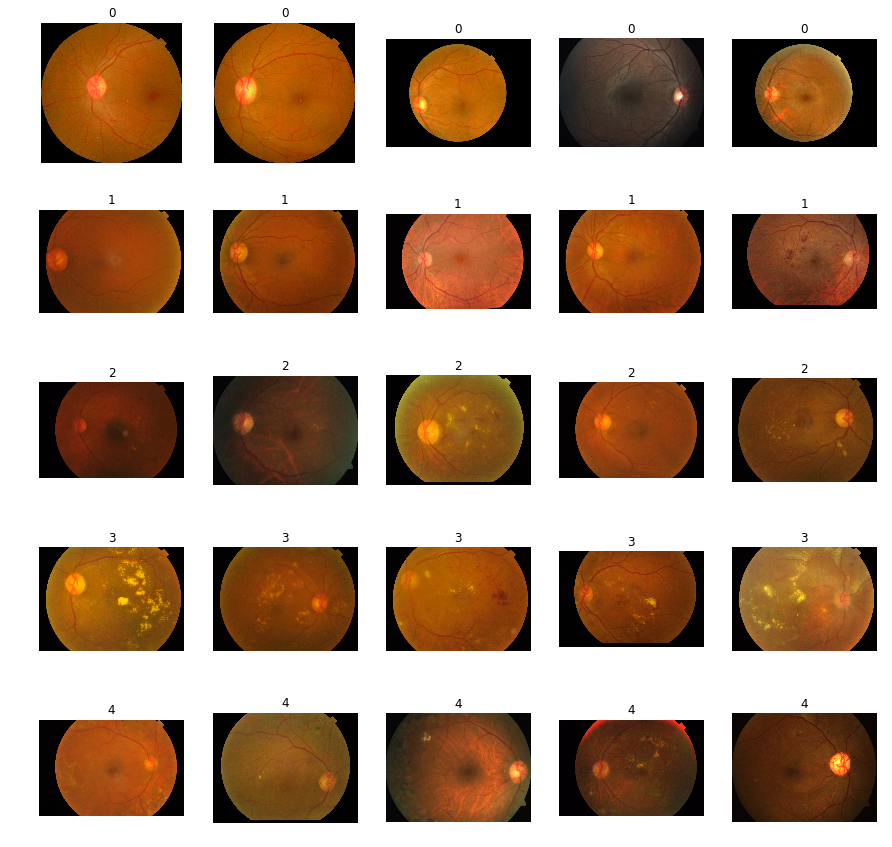

In [8]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*edge_len, nrows*edge_len)
    
for i, img_path in enumerate(pics):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(str(ALL_DIR/img_path))
    plt.imshow(img)
    
    label = train_df.loc[train_df.id_code_png == img_path]["diagnosis"].values[0]
    plt.title(label)

plt.show()


# split data

In [10]:
val_pct = .2

for fname in os.listdir(str(ALL_DIR)):
    
    if random.random()< val_pct:
        
        shutil.move(str(ALL_DIR/fname),str(ALL_TEST_DIR/fname))

# unsplit data

In [9]:
for fname in os.listdir(str(ALL_TEST_DIR)):
            
        shutil.move(str(ALL_TEST_DIR/fname),str(ALL_DIR/fname))

# data augmentation

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 360)

test_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 360)

# data generators

In [12]:
%%time

train_datagen = train_datagen.flow_from_dataframe(
    directory=str(ALL_DIR),  # This is the source directory for training images
    dataframe = train_df,
    x_col = 'id_code_png',
    y_col = 'diagnosis',
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='other')

test_datagen = test_datagen.flow_from_dataframe(
    directory=str(ALL_TEST_DIR),  # This is the source directory for training images
    dataframe = train_df,
    x_col = 'id_code_png',
    y_col = 'diagnosis',
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='other')

Found 2931 images.
Found 731 images.
CPU times: user 453 ms, sys: 356 ms, total: 808 ms
Wall time: 2.43 s


# pretrained model

In [23]:
%%time

from tensorflow.keras.applications.inception_v3 import InceptionV3

pretrained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')



CPU times: user 9.06 s, sys: 314 ms, total: 9.38 s
Wall time: 9.23 s


In [24]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_94 (Batc (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1_94[0][0]  
_______________________________________________________________________________________

__________________________________________________________________________________________________
activation_170 (Activation)     (None, 3, 3, 320)    0           batch_normalization_v1_170[0][0] 
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 3, 3, 768)    0           activation_172[0][0]             
                                                                 activation_173[0][0]             
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 3, 3, 768)    0           activation_176[0][0]             
                                                                 activation_177[0][0]             
__________________________________________________________________________________________________
activation_178 (Activation)     (None, 3, 3, 192)    0           batch_normalization_v1_178[0][0] 
__________

# choose last layer

In [ ]:
LAYER_NAME = 'mixed7'

In [ ]:
last_layer = pre_trained_model.get_layer(LAYER_NAME)

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

# custom head architecture

In [ ]:
%%time

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense  (1, activation='linear')(x)           

%%time

model = Model( pre_trained_model.input, x) 

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
____________________________________________________________________________________________

In [31]:
model.layers

# freeze pretrain

In [34]:
LAST_INDEX = -6

In [35]:
for layer in model.layers[:LAST_INDEX]:
    
    layer.trainable=False

# unfreeze pretrain

In [37]:
for layer in model.layers[:LAST_INDEX]:
    
    layer.trainable=True

# compile model

In [39]:
%%time

model.compile(optimizer = Adam(), 
              loss = 'mean_squared_error', 
              metrics = ['acc'])

CPU times: user 150 ms, sys: 3.68 ms, total: 154 ms
Wall time: 152 ms


# define callbacks

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

# train model
NOTE: 8min/epoch on k80

In [40]:
# TIME: 8mins/epoch on k80

history = model.fit_generator(
            train_datagen,
            validation_data = test_datagen,
            epochs = 1,
            verbose = 2)

90/90 - 588s - loss: 1.0904 - acc: 0.3689 - val_loss: 2.8285 - val_acc: 0.4615


# test model

In [90]:
%%time

os.chdir(str(ALL_TEST_DIR))

y_pred = []

y_true = []

val_n = len(os.listdir(str(ALL_TEST_DIR)))

for index,fname in enumerate(os.listdir(str(ALL_TEST_DIR))):
    
    #label
    diagnosis = int(train_df.loc[train_df.id_code == fname[:-4]].diagnosis)  
    y_true += [diagnosis]
        
    img = image.load_img(fname,target_size=(150,150))
    
    x = image.img_to_array(img)/255.
    
    x = np.expand_dims(x, axis=0)
    
    images = np.vstack([x])
    
    classes = model.predict(images, batch_size=10)
    
    y_pred += [classes[0][0]]
    
    if index%50 == 0:
        
        print(int(index/val_n * 100))
    
for index, pred in enumerate(y_pred):
    
    y_pred[index] = int(round(pred))
    
y_pred, y_true = np.array(y_pred), np.array(y_true)

0
6
13
20
27
34
41
47
54
61
68
75
82
88
95
CPU times: user 1min 49s, sys: 4.78 s, total: 1min 53s
Wall time: 1min 53s


In [76]:
pd.Series(y_true).describe()

count    731.000000
mean       1.127223
std        1.320631
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        4.000000
dtype: float64

In [77]:
pd.Series(y_pred).describe()

count    731.000000
mean       0.487004
std        0.595217
min       -1.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        3.000000
dtype: float64

In [88]:
%%time

mae = sklearn.metrics.mean_absolute_error(y_true, y_pred)
mse = sklearn.metrics.mean_squared_error(y_true, y_pred)
medse = sklearn.metrics.median_absolute_error(y_true, y_pred)

print('\n','mae =',mae,'\n','mse =',mse,'\n','medse =',medse,'\n')


 mae = 0.66484268125855 
 mse = 1.2886456908344732 
 medse = 0.0 

CPU times: user 142 µs, sys: 4.02 ms, total: 4.16 ms
Wall time: 3 ms


# save model
- NOTE: uploading new model to kaggle takes time

In [ ]:
%%time

os.chdir(str(PROJECT_DIR))

model.save('model_c.h5')

# load model

In [13]:
%%time

os.chdir(str(PROJECT_DIR))

model = models.load_model('model_b.h5')

CPU times: user 9.41 s, sys: 1.57 s, total: 11 s
Wall time: 19.2 s
